# Bluenoise generator

## Imports

In [11]:
from __future__ import with_statement

# exports
import csv
import binascii

# scientific
import math
import numpy as np
import pylab as pl

# local imports
from poisson_disk.poisson_disk import *
from poisson_disk.enhanced_grid import *

## Blue noise class

In [14]:
class blue_noise_generator:
  """ Class for creating blue noise """
  def __init__(self, file_name="points", width=100, height=100, k=30, radius=1, missing_nozzles=None, plot_display=True, create_csv=False, create_msk=True, correct_nozzle=True):
    """ Blue noise constructor takes a variety of input parameters
    :param string csv_file_name: csv output file name in script folder
    :param int width: width of blue noise area in pixel
    :param int height: height of blue noise area in pixel
    :param int k: iteration to perform of finding the perfect blue noise 30 is a good value
    :param int radius: distance in pixels between the points (1.1 = ~50% | 1.65= ~25%
    :param bool plot_display: enables display of a mathplot in the end
    :param bool create_csv: enables csv creation with the given name
    """
    # Read input arguments
    self.width           = width
    self.height          = height
    self.k               = k
    self.radius          = radius
    self.file_name       = file_name
    self.plot_display    = plot_display
    self.create_csv      = create_csv
    self.create_msk      = create_msk
    self.correct_nozzle  = correct_nozzle
    self.missing_nozzles = missing_nozzles

    # Do program
    self.points_int, self.points_float = self.generate_noise(self.width, self.height, self.radius, self.k)
    self.statistic(self.width, self.height, self.points_float)
    if self.plot_display:
      self.plot(self.points_int, self.points_float)
    self.grid  = self.create_grid(self.width, self.height, self.points_int)
    if (self.width == 64 and self.height == 1280):
      # Create left and write mask
      (self.grid_left, self.grid_right) = self.create_full_mask(self.width, self.height, self.grid)
      # Correct nozzles in these masks
      if self.correct_nozzle:
        (self.grid_left, self.grid_right) = self.correct_missing_nozzle(self.missing_nozzles, self.grid_left, self.grid_right)
      # Write outputs
      if self.create_csv:
        print(self.write_csv(self.file_name + "_left", self.grid_left))
        print(self.write_csv(self.file_name + "_right", self.grid_right))
      if self.create_msk:
        print(self.write_msk(self.file_name + "_left", self.grid_left))
        print(self.write_msk(self.file_name + "_right", self.grid_right))

    if self.create_csv:
      print(self.write_csv(self.file_name, self.grid))



  def generate_noise(self, width, height, radius, k):
    """ Create blue noise with the poisson_disk algorithm
    :param int width: width of blue noise area in pixel
    :param int height: height of blue noise area in pixel
    :param int k: iteration to perform of finding the perfect blue noise 30 is a good value
    :param int radius: distance in pixels between the points (1.1 = ~50% | 1.65= ~25%
    :returns list: 2D list of all Floating point values and 2D list of all integer values
    """
    # create radius grid
    r_grid = Grid2D((self.width, self.height), self.radius)
    # perform poisson_disk algorithm
    points_float =  sample_poisson(width, height, r_grid, k)
    points_int  = [[[] for ni in range(len(points_float[0]))] for mi in range(len(points_float))]
    # Convert to int
    for x in range(len(points_float)):
      for y in range(len(points_float[x])):
        points_int[x][y] = int(points_float[x][y])
    return points_int, points_float

  def statistic(self, width, height, points_float):
    """ Calculate and display some statistics
    :param int width: width of blue noise area in pixel
    :param int height: height of blue noise area in pixel
    :param float[][] pints_float: 2D vector of the floating blue noise values
    """
    # Count elements
    print("Count Total = {}  Count X = {}".format(width * height, len(points_float)))
    print("Percent enabled = {}%".format(100/float(width * height)*float(len(points_float))))

  def plot(self, points_int, points_float):
    """ Plot exact and integer values in mathplot
    :param float[][] pints_float: 2D vector of the floating blue noise values
    :param int[][] pints_int: 2D vector of the int blue noise values
    """
    # Plot values
    # Transpose array
    points_f_t = list(zip(*points_float))
    points_i_t = list(zip(*points_int))
    #for row in points:
    #  print(row)
    #for row in points_t:
    #  print(row)
    pl.clf()
    pl.figure(figsize=(11,5))
    pl.subplot(1,2,1)
    pl.plot(points_f_t[0],points_f_t[1], 'o', label="float")
    pl.title("Blue Noise pattern exact")
    pl.draw()
    pl.subplot(1,2,2)
    pl.plot(points_i_t[0],points_i_t[1], 'o', label="integer")
    pl.title("Blue Noise pattern integer")
    pl.draw()

  def create_grid(self, width, height, points_int):
    """ Convert the point values in a pixelsize grid
    :param int width: width of blue noise area in pixel
    :param int height: height of blue noise area in pixel
    :param int[][] pints_int: 2D vector of the int blue noise values
    :returns int[][]: Returns grid 2D list
    """
    # create grid
    grid = [[[] for ni in range(width)] for mi in range(height)]
    # Fill all with 0
    for x in range(len(grid)):
      for y in range(len(grid[x])):
        grid[x][y] = 0
    # Fill points with 1
    for y,x in points_int:
      grid[int(x)][int(y)] = 1
    return grid

  def create_full_mask(self, width, height, grid):
    """ Creates full mask with stitching area (hacked for Ricoh Gen5 size only)
    +---------------+
    |               | 0
    |       B       |
    |               | 7
    +---------------+
    |               | 8
    |               |
    |               |
    |       A       |
    |               |
    |               |
    |               | 1271
    +---------------+
    |               | 1272
    |      ~B       |
    |               | 1279
    +---------------+
    """
    # Stitching constants
    self.stitching       = 8
    self.stitch_top_up   = 0                                       # 0
    self.stitch_top_down = self.stitch_top_up + self.stitching - 1 # 7
    self.stitch_bot_up   = height - self.stitching                 # 1272
    self.stitch_bot_down = height - 1                              # 1279
    grid_full  = [[[] for ni in range(width)] for mi in range(height)]

    # Copy A
    for y in range(self.stitch_top_up, self.stitch_bot_up): # 0-1271
      for x in range(0, width):
        grid_full[y][x] = grid[y][x]
    # Copy ~A
    for y in range(self.stitch_bot_up, self.stitch_bot_down+1): # 1272-1279
      for x in range(0, width):
        if grid[y-self.stitch_bot_up][x] == 1:
          grid_full[y][x] = 0
        else:
          grid_full[y][x] = 1

    grid_left  = self.create_left_mask(width, height, grid_full)
    grid_right = self.create_right_mask(width, height, grid_full)

    self.check_grid_masks(width, height, grid_left, grid_right)

    return (grid_left, grid_right)

  def create_left_mask(self, width, height, grid_full):
    """ Create mask for left row (hacked for Ricoh Gen5 size only)
    +---------------+
    |   |   |   |   | 0
    | B | 0 | B | 0 |
    |   |   |   |   | 7
    +---------------+
    |               | 8
    |               |
    |               |
    |       A       |
    |               |
    |               |
    |               | 1271
    +---------------+
    |   |   |   |   | 1272
    |~B | 0 |~B | 0 |
    |   |   |   |   | 1279
    +---------------+
    """
    grid_left  = [[[] for ni in range(width)] for mi in range(height)]
    # Copy stitching area A | 0
    for y in range(self.stitch_top_up, self.stitch_top_down+1): # 0-7
      for x in range(0, width, 2): # 0-64 only   even numbers 0, 2, 4, ...
        grid_left[y][x] = grid_full[y][x]
      for x in range(1, width, 2): # 0-64 only uneven numbers 1, 3, 5, ...
        grid_left[y][x] = 0
    # Copy A
    for y in range(self.stitch_top_down+1, self.stitch_bot_up): # 8-1271
      for x in range(0, width):
        grid_left[y][x] = grid_full[y][x]
    # Copy stitching area ~A | 0
    for y in range(self.stitch_bot_up, self.stitch_bot_down+1): # 1272-1279
      for x in range(0, width, 2): # 0-64 only   even numbers 0, 2, 4, ...
        grid_left[y][x] = grid_full[y][x]
      for x in range(1, width, 2): # 0-64 only uneven numbers 1, 3, 5, ...
        grid_left[y][x] = 0
    return grid_left

  def create_right_mask(self, width, height, grid_full):
    """ Create mask for right row (hacked for Ricoh Gen5 size only)
    +---------------+
    |   |   |   |   | 0
    | 0 | B | 0 | B |
    |   |   |   |   | 7
    +---------------+
    |               | 8
    |               |
    |               |
    |      ~A       |
    |               |
    |               |
    |               | 1271
    +---------------+
    |   |   |   |   | 1272
    | 0 |~B | 0 |~B |
    |   |   |   |   | 1279
    +---------------+
    """
    grid_right  = [[[] for ni in range(width)] for mi in range(height)]
    # Copy stitching area 0 | A
    for y in range(self.stitch_top_up, self.stitch_top_down+1): # 0-7
      for x in range(0, width, 2): # 0-64 only   even numbers 0, 2, 4, ...
        grid_right[y][x] = 0
      for x in range(1, width, 2): # 0-64 only uneven numbers 1, 3, 5, ...
        grid_right[y][x] = grid_full[y][x]
    # Copy ~A (need to invert)
    for y in range(self.stitch_top_down+1, self.stitch_bot_up): # 8-1271
      for x in range(0, width):
        if grid_full[y][x] == 1:
          grid_right[y][x] = 0
        else:
          grid_right[y][x] = 1
    # Copy stitching area 0 | ~A
    for y in range(self.stitch_bot_up, self.stitch_bot_down+1): # 1272-1279
      for x in range(0, width, 2): # 0-64 only   even numbers 0, 2, 4, ...
        grid_right[y][x] = 0
      for x in range(1, width, 2): # 0-64 only uneven numbers 1, 3, 5, ...
        grid_right[y][x] = grid_full[y][x]
    return grid_right

  def check_grid_masks(self, width, height, grid_left, grid_right):
    """ Checks if the grid is correct
    """
    grid_check  = [[[] for ni in range(width)] for mi in range(height)]
    for y in range(len(grid_left)):
      for x in range(len(grid_left[0])):
        grid_check[y][x] = grid_left[y][x] + grid_right[y][x]

  def correct_missing_nozzle(self, missing_nozzles, grid_left, grid_right):
    """ Corrects missing noozles in some of the printheads
    :param int[[][]] mizzing_noozles: 2D list noozlenumber and printhead number
    :param int[][] grid_left : 2D list of printhead left mask values
    :param int[][] grid_right: 2D list of printhead right mask values
    DOES NOT CHECK STITCHING AREA AT THE MOMENT
    """
    if not(missing_nozzles == None):
      for missing_nozzle in missing_nozzles:
        if missing_nozzle[0] == 0: # left PH
          for x in range(len(grid_left[0])):
            grid_left[missing_nozzle[1]][x]  = 0
            grid_right[missing_nozzle[1]][x] = 1
        else:                      # right PH
          for x in range(len(grid_left[0])):
            grid_left[missing_nozzle[1]][x]  = 1
            grid_right[missing_nozzle[1]][x] = 0
    return (grid_left,grid_right)


  def write_csv(self, file_name, grid):
    """ Export the grid into a csv table for easier copying into the excel sheet
    :param string file_name: csv output file name in script folder
    :param int[][] grid: 2D list of values to store
    :returns string: Error of Successmessage
    """
    # Write File
    filepath = "../out/{}.csv".format(file_name)
    with open(filepath, 'w') as csvfile:
      csvwriter = csv.writer(csvfile, delimiter=';')#, quotechar='|', quoting=csv.QUOTE_MINIMAL)
      for row in grid:
        csvwriter.writerow(row)
      return "Data saved in {} file ".format(filepath)
    return "Error csv file not correctly saved"

  def write_msk(self, file_name, grid):
    """ Export the grid into a msk binary file which can be directly used in the PLC mask uploader
    :param string file_name: csv output file name in script folder
    :param int[][] grid: 2D list of values to store
    :returns string: Error of Successmessage
    """
    # Convert Values to number
    bin_ascii_list = []
    for y in range(len(grid)):
      bin_ascii = ""
      for x in range(len(grid[y])):
        bin_ascii = bin_ascii + str(grid[y][x])
      bin_ascii_list.append(bin_ascii)

    hex_binary_list = []
    for bin_ascii in bin_ascii_list:
      hex_ascii = ""
      for i in range(0,len(bin_ascii),4):
        if bin_ascii[i:i+4] == "0000":
          hex_ascii = hex_ascii + "0"
        else:
          hex_ascii = hex_ascii + hex(int(bin_ascii[i:i+4], 2))[2:]
      #print("bin_ascii = {} hex_ascii = {} hex_binary= {}".format(bin_ascii, hex_ascii, binascii.a2b_hex(hex_ascii)))
      hex_binary_list.append(binascii.a2b_hex(hex_ascii))

    # Write file
    filepath = "../out/{}.msk".format(file_name)
    with open(filepath, 'wb') as mskfile:
      for hex_binary in hex_binary_list:
        mskfile.write(hex_binary)
      return "Data saved in {} file ".format(filepath)
    return "Error msk file not correctly saved"



## Main

In [15]:
# Ricoh Gen
#noise_generator = blue_noise_generator(file_name="ri_gen5", width=64, height=1280, radius=1.1, plot_display=True, create_csv=True, create_msk=True, correct_nozzle=True)
##noise_generator = blue_noise_generator(file_name="ri_gen5", width=64, height=1280, radius=1.1, missing_nozzles=[[0,0],[1,1]], plot_display=True, create_csv=True, create_msk=True, correct_nozzle=True)
##noise_generator = blue_noise_generator(file_name="ri_gen4", width=64, height=384, radius=1.1, missing_nozzles=[[0,0],[1,1]], plot_display=True, create_csv=True, create_msk=True, correct_nozzle=True)
# KY_KJ4B_40k
#noise_generator = blue_noise_generator(file_name="ky_kj4b_40k", width=64, height=2656, radius=1.1, plot_display=True, create_csv=True, create_msk=True, correct_nozzle=True)
# KM1024i
noise_generator = blue_noise_generator(file_name="km1024i", width=64, height=1024, radius=1.1, plot_display=True, create_csv=True, create_msk=True)

RuntimeError: generator raised StopIteration

In [40]:
# BlueNoise.py - An implementation of the void and cluster method for generation of 
#                blue noise dither arrays and related utilities.
#
# Written in 2016 by Christoph Peters, Christoph(at)MomentsInGraphics.de
#
# To the extent possible under law, the author(s) have dedicated all copyright and 
# related and neighboring rights to this software to the public domain worldwide. 
# This software is distributed without any warranty.
#
# You should have received a copy of the CC0 Public Domain Dedication along with 
# this software. If not, see <http://creativecommons.org/publicdomain/zero/1.0/>. 

from os import path,makedirs
import numpy as np
from scipy import ndimage
from matplotlib import pyplot
import png
import threading
import struct

def GetBayerPattern(Log2Width):
    """Creates a two-dimensional Bayer pattern with a width and height of 
       2**Log2Width."""
    X,Y=np.meshgrid(range(2**Log2Width),range(2**Log2Width));
    Result=np.zeros_like(X);
    for i in range(Log2Width):
        StripesY=np.where(np.bitwise_and(Y,2**(Log2Width-1-i))!=0,1,0);
        StripesX=np.where(np.bitwise_and(X,2**(Log2Width-1-i))!=0,1,0);
        Checker=np.bitwise_xor(StripesX,StripesY);
        Result+=np.bitwise_or(StripesY*2**(2*i),Checker*2**(2*i+1));
    return Result;


def FindLargestVoid(BinaryPattern,StandardDeviation):
    """This function returns the indices of the largest void in the given binary 
       pattern as defined by Ulichney.
      \param BinaryPattern A boolean array (should be two-dimensional although the 
             implementation works in arbitrary dimensions).
      \param StandardDeviation The standard deviation used for the Gaussian filter 
             in pixels. This can be a single float for an isotropic Gaussian or a 
             tuple with one float per dimension for an anisotropic Gaussian.
      \return A flat index i such that BinaryPattern.flat[i] corresponds to the 
              largest void. By definition this is a majority pixel.
      \sa GetVoidAndClusterBlueNoise"""
    # The minority value is always True for convenience
    if(np.count_nonzero(BinaryPattern)*2>=np.size(BinaryPattern)):
        BinaryPattern=np.logical_not(BinaryPattern);
    # Apply the Gaussian. We do not want to cut off the Gaussian at all because even 
    # the tiniest difference can change the ranking. Therefore we apply the Gaussian 
    # through a fast Fourier transform by means of the convolution theorem.
    FilteredArray=np.fft.ifftn(ndimage.fourier.fourier_gaussian(np.fft.fftn(np.where(BinaryPattern,1.0,0.0)),StandardDeviation)).real;
    # Find the largest void
    return np.argmin(np.where(BinaryPattern,2.0,FilteredArray));


def FindTightestCluster(BinaryPattern,StandardDeviation):
    """Like FindLargestVoid() but finds the tightest cluster which is a minority 
       pixel by definition.
      \sa GetVoidAndClusterBlueNoise"""
    if(np.count_nonzero(BinaryPattern)*2>=np.size(BinaryPattern)):
        BinaryPattern=np.logical_not(BinaryPattern);
    FilteredArray=np.fft.ifftn(ndimage.fourier.fourier_gaussian(np.fft.fftn(np.where(BinaryPattern,1.0,0.0)),StandardDeviation)).real;
    return np.argmax(np.where(BinaryPattern,FilteredArray,-1.0));


def GetVoidAndClusterBlueNoise(OutputShape,StandardDeviation=1.5,InitialSeedFraction=0.1):
    """Generates a blue noise dither array of the given shape using the method 
       proposed by Ulichney [1993] in "The void-and-cluster method for dither array 
       generation" published in Proc. SPIE 1913. 
      \param OutputShape The shape of the output array. This function works in 
             arbitrary dimension, i.e. OutputShape can have arbitrary length. Though 
             it is only tested for the 2D case where you should pass a tuple 
             (Height,Width).
      \param StandardDeviation The standard deviation in pixels used for the 
             Gaussian filter defining largest voids and tightest clusters. Larger 
             values lead to more low-frequency content but better isotropy. Small 
             values lead to more ordered patterns with less low-frequency content.
             Ulichney proposes to use a value of 1.5. If you want an anisotropic 
             Gaussian, you can pass a tuple of length len(OutputShape) with one 
             standard deviation per dimension.
      \param InitialSeedFraction The only non-deterministic step in the algorithm 
             marks a small number of pixels in the grid randomly. This parameter 
             defines the fraction of such points. It has to be positive but less 
             than 0.5. Very small values lead to ordered patterns, beyond that there 
             is little change.
      \return An integer array of shape OutputShape containing each integer from 0 
              to np.prod(OutputShape)-1 exactly once."""
    nRank=np.prod(OutputShape);
    # Generate the initial binary pattern with a prescribed number of ones
    nInitialOne=max(1,min(int((nRank-1)/2),int(nRank*InitialSeedFraction)));
    # Start from white noise (this is the only randomized step)
    InitialBinaryPattern=np.zeros(OutputShape,dtype=np.bool);
    InitialBinaryPattern.flat=np.random.permutation(np.arange(nRank))<nInitialOne;
    # Swap ones from tightest clusters to largest voids iteratively until convergence
    while(True):
        iTightestCluster=FindTightestCluster(InitialBinaryPattern,StandardDeviation);
        InitialBinaryPattern.flat[iTightestCluster]=False;
        iLargestVoid=FindLargestVoid(InitialBinaryPattern,StandardDeviation);
        if(iLargestVoid==iTightestCluster):
            InitialBinaryPattern.flat[iTightestCluster]=True;
            # Nothing has changed, so we have converged
            break;
        else:
            InitialBinaryPattern.flat[iLargestVoid]=True;
    # Rank all pixels
    DitherArray=np.zeros(OutputShape,dtype=np.int);
    # Phase 1: Rank minority pixels in the initial binary pattern
    BinaryPattern=np.copy(InitialBinaryPattern);
    for Rank in range(nInitialOne-1,-1,-1):
        iTightestCluster=FindTightestCluster(BinaryPattern,StandardDeviation);
        BinaryPattern.flat[iTightestCluster]=False;
        DitherArray.flat[iTightestCluster]=Rank;
    # Phase 2: Rank the remainder of the first half of all pixels
    BinaryPattern=InitialBinaryPattern;
    for Rank in range(nInitialOne,int((nRank+1)/2)):
        iLargestVoid=FindLargestVoid(BinaryPattern,StandardDeviation);
        BinaryPattern.flat[iLargestVoid]=True;
        DitherArray.flat[iLargestVoid]=Rank;
    # Phase 3: Rank the last half of pixels
    for Rank in range(int((nRank+1)/2),nRank):
        iTightestCluster=FindTightestCluster(BinaryPattern,StandardDeviation);
        BinaryPattern.flat[iTightestCluster]=True;
        DitherArray.flat[iTightestCluster]=Rank;
    return DitherArray;


def AnalyzeNoiseTexture(Texture,SingleFigure=True,SimpleLabels=False):
    """Given a 2D array of real noise values this function creates one or more 
       figures with plots that allow you to analyze it, especially with respect to 
       blue noise characteristics. The analysis includes the absolute value of the 
       Fourier transform, the power distribution in radial frequency bands and an 
       analysis of directional isotropy.
      \param A two-dimensional array.
      \param SingleFigure If this is True, all plots are shown in a single figure, 
             which is useful for on-screen display. Otherwise one figure per plot 
             is created.
      \param SimpleLabels Pass True to get axis labels that fit into the context of 
             the blog post without further explanation.
      \return A list of all created figures.
      \note For the plots to show you have to invoke pyplot.show()."""
    FigureList=list();
    if(SingleFigure):
        Figure=pyplot.figure();
        FigureList.append(Figure);
    def PrepareAxes(iAxes,**KeywordArguments):
        if(SingleFigure):
            return Figure.add_subplot(2,2,iAxes,**KeywordArguments);
        else:
            NewFigure=pyplot.figure();
            FigureList.append(NewFigure);
            return NewFigure.add_subplot(1,1,1,**KeywordArguments);
    # Plot the dither array itself
    PrepareAxes(1,title="Blue noise dither array");
    pyplot.imshow(Texture.real,cmap="gray",interpolation="nearest");
    # Plot the Fourier transform with frequency zero shifted to the center
    PrepareAxes(2,title="Fourier transform (absolute value)",xlabel="$\\omega_x$",ylabel="$\\omega_y$");
    DFT=np.fft.fftshift(np.fft.fft2(Texture))/float(np.size(Texture));
    Height,Width=Texture.shape;
    ShiftY,ShiftX=(int(Height/2),int(Width/2));
    pyplot.imshow(np.abs(DFT),cmap="viridis",interpolation="nearest",vmin=0.0,vmax=np.percentile(np.abs(DFT),99),extent=(-ShiftX-0.5,Width-ShiftX-0.5,-ShiftY+0.5,Height-ShiftY+0.5));
    pyplot.colorbar();
    # Plot the distribution of power over radial frequency bands
    PrepareAxes(3,title="Radial power distribution",xlabel="Distance from center / pixels" if SimpleLabels else "$\\sqrt{\\omega_x^2+\\omega_y^2}$");
    X,Y=np.meshgrid(range(DFT.shape[1]),range(DFT.shape[0]));
    X-=int(DFT.shape[1]/2);
    Y-=int(DFT.shape[0]/2);
    RadialFrequency=np.asarray(np.round(np.sqrt(X**2+Y**2)),dtype=np.int);
    RadialPower=np.zeros((np.max(RadialFrequency)-1,));
    DFT[int(DFT.shape[0]/2),int(DFT.shape[1]/2)]=0.0;
    for i in range(RadialPower.shape[0]):
        RadialPower[i]=np.sum(np.where(RadialFrequency==i,np.abs(DFT),0.0))/np.count_nonzero(RadialFrequency==i);
    pyplot.plot(np.arange(np.max(RadialFrequency)-1)+0.5,RadialPower);
    # Plot the distribution of power over angular frequency ranges
    PrepareAxes(4,title="Anisotropy (angular power distribution)",aspect="equal",xlabel="Frequency x" if SimpleLabels else "$\\omega_x$",ylabel="Frequency y" if SimpleLabels else "$\\omega_y$");
    CircularMask=np.logical_and(0<RadialFrequency,RadialFrequency<int(min(DFT.shape[0],DFT.shape[1])/2));
    NormalizedX=np.asarray(X,dtype=np.float)/np.maximum(1.0,np.sqrt(X**2+Y**2));
    NormalizedY=np.asarray(Y,dtype=np.float)/np.maximum(1.0,np.sqrt(X**2+Y**2));
    BinningAngle=np.linspace(0.0,2.0*np.pi,33);
    AngularPower=np.zeros_like(BinningAngle);
    for i,Angle in enumerate(BinningAngle):
        DotProduct=NormalizedX*np.cos(Angle)+NormalizedY*np.sin(Angle);
        FullMask=np.logical_and(CircularMask,DotProduct>=np.cos(np.pi/32.0));
        AngularPower[i]=np.sum(np.where(FullMask,np.abs(DFT),0.0))/np.count_nonzero(FullMask);
    MeanAngularPower=np.mean(AngularPower[1:]);
    DenseAngle=np.linspace(0.0,2.0*np.pi,256);
    pyplot.plot(np.cos(DenseAngle)*MeanAngularPower,np.sin(DenseAngle)*MeanAngularPower,color=(0.7,0.7,0.7));
    pyplot.plot(np.cos(BinningAngle)*AngularPower,np.sin(BinningAngle)*AngularPower);
    return FigureList;


def PlotBinaryPatterns(Texture,nPatternRow,nPatternColumn):
    """This function creates a figure with a grid of thresholded versions of the 
       given 2D noise texture. It assumes that each value from 0 to 
       np.size(Texture)-1 is contained exactly once.
      \return The created figure.
      \note For the plots to show you have to invoke pyplot.show()."""
    Figure=pyplot.figure();
    nPattern=nPatternRow*nPatternColumn+1;
    for i in range(1,nPattern):
        Figure.add_subplot(nPatternRow,nPatternColumn,i,xticks=[],yticks=[]);
        pyplot.imshow(np.where(Texture*nPattern<i*np.size(Texture),1.0,0.0),cmap="gray",interpolation="nearest");
    return Figure;


def StoreNoiseTextureLDR(Texture,OutputPNGFilePath,nRank=-1):
    """This function stores the given texture to a standard low-dynamic range png 
       file with four channels and 8 bits per channel.
      \param Texture An array of shape (Height,Width) or (Height,Width,nChannel). 
             The former is handled like (Height,Width,1). If nChannel>4 the 
             superfluous channels are ignored. If nChannel<4 the data is expanded. 
             The alpha channel is set to 255, green and blue are filled with black 
             or with duplicates of red if nChannel==1. It is assumed that each 
             channel contains every integer value from 0 to nRank-1 exactly once. 
             The range of values is remapped linearly to span the range from 0 to 
             255.
      \param OutputPNGFilePath The path to the output png file including the file 
             format extension.
      \param nRank Defaults to Width*Height if you pass a non-positive value."""
    # Scale the array to an LDR version
    if(nRank<=0):
        nRank=Texture.shape[0]*Texture.shape[1];
    Texture=np.asarray((Texture*256)//nRank,dtype=np.uint8);
    # Get a three-dimensional array
    if(len(Texture.shape)<3):
        Texture=Texture[:,:,np.newaxis];
    # Generate channels as needed
    if(Texture.shape[2]==1):
        Texture=np.dstack([Texture]*3+[255*np.ones_like(Texture[:,:,0])]);
    elif(Texture.shape[2]==2):
        Texture=np.dstack([Texture[:,:,0],Texture[:,:,1]]+[np.zeros_like(Texture[:,:,0])]+[255*np.ones_like(Texture[:,:,0])]);
    elif(Texture.shape[2]==3):
        Texture=np.dstack([Texture[:,:,0],Texture[:,:,1],Texture[:,:,2]]+[255*np.ones_like(Texture[:,:,0])]);
    elif(Texture.shape[2]>4):
        Texture=Texture[:,:,:4];
    # Ravel width and channel count to meet pypng requirements
    Texture=Texture.reshape((Texture.shape[0],-1))
    # Save the image
    png.from_array(Texture,"RGBA;8").save(OutputPNGFilePath);


def StoreNoiseTextureHDR(Texture,OutputPNGFilePath,nRank=-1):
    """This function stores the given texture to an HDR png file with 16 bits per 
       channel and the specified number of channels.
      \param Texture An array of shape (Height,Width) or (Height,Width,nChannel). 
             The former is handled like (Height,Width,1). It is assumed that each 
             channel contains each integer value from 0 to nRank-1 exactly once. The 
             range of values is remapped linearly to span the range from 0 to 
             2**16-1 supported by the output format. nChannel can be 1, 2, 3 or 4.
      \param OutputPNGFilePath The path to the output *.png file including the file 
             format extension.
      \param nRank Defaults to Width*Height if you pass a non-positive value."""
    # Scale the array to an HDR version
    if(nRank<=0):
        nRank=Texture.shape[0]*Texture.shape[1];
    Texture=np.asarray((np.asarray(Texture,dtype=np.uint64)*(2**16))//nRank,dtype=np.uint16);
    # Get a three-dimensional array
    if(len(Texture.shape)<3):
        Texture=Texture[:,:,np.newaxis];
    # Save the image
    Mode=["L","LA","RGB","RGBA"][Texture.shape[2]-1]+";16";
    Texture=Texture.reshape((Texture.shape[0],-1))
    png.from_array(Texture,Mode).save(OutputPNGFilePath);


def StoreNDTextureHDR(Array,OutputFilePath):
    """This function stores the given unsigned integer array in a minimalist binary 
       file format. The last dimension is interpreted as corresponding to the 
       channels of the image. The file format consists of a sequence of unsigned, 
       least significant bit first 32-bit integers. The contained data is described 
       below:
      - Version: File format version, should be 1.
      - nChannel: The number of color channels in the image. This should be a value 
        between 1 (greyscale) and 4 (RGBA).
      - nDimension: The number of dimensions of the stored array, i.e. the number of 
        indices required to uniquely identify one pixel, voxel, etc..
      - Shape[nDimension]: nDimension integers providing the size of the array along 
        each dimension. By convention the first dimension is height, second width 
        and third depth.
      - Data[Shape[0]*...*Shape[nDimension-1]*nChannel]: The uncompressed data of 
        the array. The channels are unrolled first, followed by all dimensions in 
        reverse order. Thus, an RG image of size 3*2 would be stored in the 
        following order: 00R, 00G, 01R, 01G, 10R, 10G, 11R, 11G, 20R, 20G, 21R, 
        21G"""
    # Prepare all the meta data and the data itself
    Array=np.asarray(Array,dtype=np.uint32);
    Version=1;
    nDimension=len(Array.shape)-1;
    nChannel=Array.shape[nDimension];
    Shape=Array.shape[0:nDimension];
    Data=Array.flatten("C");
    # Write it to the file
    OutputFile=open(OutputFilePath,"wb");
    OutputFile.write(struct.pack("LLL",Version,nChannel,nDimension));
    OutputFile.write(struct.pack("L"*nDimension,*Shape));
    OutputFile.write(struct.pack("L"*np.size(Data),*Data));
    OutputFile.close();


def LoadNDTextureHDR(SourceFilePath):
    """Loads a file generated by StoreNDTextureHDR() and returns it as an array like 
       the one that goes into StoreNDTextureHDR() using data type np.uint32. On 
       failure it returns None."""
    # Load the meta data
    File=open(SourceFilePath,"rb");
    Version,nChannel,nDimension=struct.unpack_from("LLL",File.read(12));
    if(Version!=1):
        return None;
    Shape=struct.unpack_from("L"*nDimension,File.read(4*nDimension));
    nScalar=np.prod(Shape)*nChannel;
    Data=struct.unpack_from("L"*nScalar,File.read(4*nScalar));
    File.close();
    # Prepare the output
    return np.asarray(Data,dtype=np.uint32).reshape(tuple(list(Shape)+[nChannel]),order="C");


def GenerateBlueNoiseDatabase(RandomSeedIndexList=range(1),MinResolution=16,MaxResolution=1024,ChannelCountList=[1,2,3,4],StandardDeviation=1.5):
    """This function generates a database of blue noise textures for all sorts of 
       use cases. It includes power-of-two resolutions from MinResolution**2 up 
       to MaxResolution**2. Textures are generated with each given number of 
       channels. Each texture is generated multiple times using different random 
       numbers per entry in RandomSeedIndexList and the entries become part of the 
       file name. StandardDeviation forwards to GetVoidAndClusterBlueNoise(). The 
       results are stored as LDR and HDR files to a well-organized tree of 
       of directories."""
    Resolution=MinResolution;
    while(Resolution<=MaxResolution):
        OutputDirectory="../Data/%d_%d"%(Resolution,Resolution);
        if(not path.exists(OutputDirectory)):
            makedirs(OutputDirectory);
        for nChannel in ChannelCountList:
            for i in RandomSeedIndexList:
                Texture=np.dstack([GetVoidAndClusterBlueNoise((Resolution,Resolution),StandardDeviation) for j in range(nChannel)]);
                LDRFormat=["LLL1","RG01","RGB1","RGBA"][nChannel-1];
                HDRFormat=["L","LA","RGB","RGBA"][nChannel-1];
                StoreNoiseTextureLDR(Texture,path.join(OutputDirectory,"LDR_%s_%d.png"%(LDRFormat,i)));
                StoreNoiseTextureHDR(Texture,path.join(OutputDirectory,"HDR_%s_%d.png"%(HDRFormat,i)));
                print("%d*%d, %s, %d"%(Resolution,Resolution,LDRFormat,i));
        Resolution*=2;


def Generate3DBlueNoiseTexture(Width,Height,Depth,nChannel,StandardDeviation=1.5):
    """This function generates a single 3D blue noise texture with the specified 
       dimensions and number of channels. It then outputs it to a sequence of Depth 
       output files in LDR and HDR in a well-organized tree of directories. It also 
       outputs raw binary files.
      \sa StoreNDTextureHDR() """
    OutputDirectory="../Data/%d_%d_%d"%(Width,Height,Depth);
    if(not path.exists(OutputDirectory)):
        makedirs(OutputDirectory);
    # Generate the blue noise for the various channels using multi-threading
    ChannelTextureList=[None]*nChannel;
    ChannelThreadList=[None]*nChannel;
    def GenerateAndStoreTexture(Index):
        ChannelTextureList[Index]=GetVoidAndClusterBlueNoise((Height,Width,Depth),StandardDeviation);
    for i in range(nChannel):
        ChannelThreadList[i]=threading.Thread(target=GenerateAndStoreTexture,args=(i,));
        ChannelThreadList[i].start();
    for Thread in ChannelThreadList:
        Thread.join();
    Texture=np.concatenate([ChannelTextureList[i][:,:,:,np.newaxis] for i in range(nChannel)],3);
    LDRFormat=["LLL1","RG01","RGB1","RGBA"][nChannel-1];
    HDRFormat=["L","LA","RGB","RGBA"][nChannel-1];
    StoreNDTextureHDR(Texture,path.join(OutputDirectory,"HDR_"+HDRFormat+".raw"));
    for i in range(Depth):
        StoreNoiseTextureLDR(Texture[:,:,i,:],path.join(OutputDirectory,"LDR_%s_%d.png"%(LDRFormat,i)),Height*Width*Depth);
        StoreNoiseTextureHDR(Texture[:,:,i,:],path.join(OutputDirectory,"HDR_%s_%d.png"%(HDRFormat,i)),Height*Width*Depth);


def GenerateNDBlueNoiseTexture(Shape,nChannel,OutputFilePath,StandardDeviation=1.5):
    """This function generates a single n-dimensional blue noise texture with the 
       specified shape and number of channels. It then outputs it to the specified 
       raw binary file.
      \sa StoreNDTextureHDR() """
    OutputDirectory=path.split(OutputFilePath)[0];
    if(not path.exists(OutputDirectory)):
        makedirs(OutputDirectory);
    # Generate the blue noise for the various channels using multi-threading
    ChannelTextureList=[None]*nChannel;
    ChannelThreadList=[None]*nChannel;
    def GenerateAndStoreTexture(Index):
        ChannelTextureList[Index]=GetVoidAndClusterBlueNoise(Shape,StandardDeviation);
    for i in range(nChannel):
        ChannelThreadList[i]=threading.Thread(target=GenerateAndStoreTexture,args=(i,));
        ChannelThreadList[i].start();
    for Thread in ChannelThreadList:
        Thread.join();
    Texture=np.concatenate([ChannelTextureList[i][...,np.newaxis] for i in range(nChannel)],len(Shape));
    StoreNDTextureHDR(Texture,OutputFilePath);


def UniformToTriangularDistribution(UniformTexture):
    """Given an array with a uniform distribution of values, this function 
       constructs an array of equal shape with a triangular distribution of values. 
       This is accomplished by applying a differentiable, monotonously growing 
       function per entry.
      \param UniformTexture An integer array containing each value from 0 to 
             np.size(UniformTexture)-1 exactly once.
      \return A floating-point array with values between -1 and 1 where the density 
              grows linearly between -1 and 0 and falls linearly between 0 and 1."""
    Normalized=(np.asarray(UniformTexture,dtype=np.float)+0.5)/float(np.size(UniformTexture));
    return np.where(Normalized<0.5,np.sqrt(2.0*Normalized)-1.0,1.0-np.sqrt(2.0-2.0*Normalized));


if(__name__=="__main__"):
    GenerateBlueNoiseDatabase(range(64),16,64,range(1,5),1.9);
    GenerateBlueNoiseDatabase(range(16),128,128,range(1,5),1.9);
    GenerateBlueNoiseDatabase(range(8),256,256,range(1,5),1.9);
    GenerateBlueNoiseDatabase(range(1),512,512,range(1,5),1.9);
    GenerateBlueNoiseDatabase(range(1),1024,1024,[4],1.9);
    for nChannel in range(1,5):
        Generate3DBlueNoiseTexture(16,16,16,nChannel,1.9);
        Generate3DBlueNoiseTexture(32,32,32,nChannel,1.9);
        Generate3DBlueNoiseTexture(64,64,64,nChannel,1.9);
        ChannelNames=["","L","LA","RGB","RGBA"][nChannel];
        GenerateNDBlueNoiseTexture((8,8,8,8),nChannel,"./Data/8_8_8_8/HDR_"+ChannelNames+".raw",1.9);
        GenerateNDBlueNoiseTexture((16,16,16,16),nChannel,"./Data/16_16_16_16/HDR_"+ChannelNames+".raw",1.9);
    Texture=GetVoidAndClusterBlueNoise((64,64),1.9);
    Texture=GetVoidAndClusterBlueNoise((32,32,32),1.9)[:,:,0];
    AnalyzeNoiseTexture(Texture,True);
    PlotBinaryPatterns(Texture,3,5);
    pyplot.show();


/var/folders/rk/v21p6_7n5rx8916y95fkbhsr0000gn/T/ipykernel_41685/2607945307.py:92: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  InitialBinaryPattern=np.zeros(OutputShape,dtype=np.bool);
/var/folders/rk/v21p6_7n5rx8916y95fkbhsr0000gn/T/ipykernel_41685/2607945307.py:106: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more

16*16, LLL1, 0
16*16, LLL1, 1
16*16, LLL1, 2
16*16, LLL1, 3
16*16, LLL1, 4
16*16, LLL1, 5
16*16, LLL1, 6
16*16, LLL1, 7
16*16, LLL1, 8
16*16, LLL1, 9
16*16, LLL1, 10
16*16, LLL1, 11
16*16, LLL1, 12
16*16, LLL1, 13
16*16, LLL1, 14
16*16, LLL1, 15
16*16, LLL1, 16
16*16, LLL1, 17
16*16, LLL1, 18
16*16, LLL1, 19
16*16, LLL1, 20
16*16, LLL1, 21
16*16, LLL1, 22
16*16, LLL1, 23
16*16, LLL1, 24
16*16, LLL1, 25
16*16, LLL1, 26
16*16, LLL1, 27
16*16, LLL1, 28
16*16, LLL1, 29
16*16, LLL1, 30
16*16, LLL1, 31
16*16, LLL1, 32
16*16, LLL1, 33
16*16, LLL1, 34
16*16, LLL1, 35
16*16, LLL1, 36
16*16, LLL1, 37
16*16, LLL1, 38
16*16, LLL1, 39
16*16, LLL1, 40
16*16, LLL1, 41
16*16, LLL1, 42
16*16, LLL1, 43
16*16, LLL1, 44
16*16, LLL1, 45
16*16, LLL1, 46
16*16, LLL1, 47
16*16, LLL1, 48
16*16, LLL1, 49
16*16, LLL1, 50
16*16, LLL1, 51
16*16, LLL1, 52
16*16, LLL1, 53
16*16, LLL1, 54
16*16, LLL1, 55
16*16, LLL1, 56
16*16, LLL1, 57
16*16, LLL1, 58
16*16, LLL1, 59
16*16, LLL1, 60
16*16, LLL1, 61
16*16, LLL1, 62
16

KeyboardInterrupt: 

/var/folders/rk/v21p6_7n5rx8916y95fkbhsr0000gn/T/ipykernel_41685/44167262.py:92: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  InitialBinaryPattern=np.zeros(OutputShape,dtype=np.bool);
/var/folders/rk/v21p6_7n5rx8916y95fkbhsr0000gn/T/ipykernel_41685/44167262.py:106: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more det

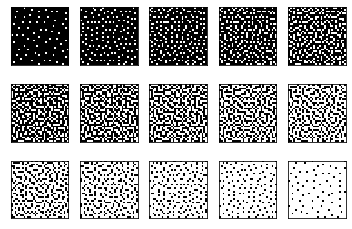

In [39]:
    Texture=GetVoidAndClusterBlueNoise((32,32),1.9);
    PlotBinaryPatterns(Texture,3,5);
    pyplot.show();

In [41]:
GenerateBlueNoiseDatabase(range(64),16,64,range(1,5),1.9);

/var/folders/rk/v21p6_7n5rx8916y95fkbhsr0000gn/T/ipykernel_41685/2607945307.py:92: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  InitialBinaryPattern=np.zeros(OutputShape,dtype=np.bool);
/var/folders/rk/v21p6_7n5rx8916y95fkbhsr0000gn/T/ipykernel_41685/2607945307.py:106: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more

16*16, LLL1, 0
16*16, LLL1, 1
16*16, LLL1, 2
16*16, LLL1, 3
16*16, LLL1, 4
16*16, LLL1, 5
16*16, LLL1, 6
16*16, LLL1, 7
16*16, LLL1, 8
16*16, LLL1, 9
16*16, LLL1, 10
16*16, LLL1, 11
16*16, LLL1, 12
16*16, LLL1, 13
16*16, LLL1, 14
16*16, LLL1, 15
16*16, LLL1, 16
16*16, LLL1, 17
16*16, LLL1, 18
16*16, LLL1, 19
16*16, LLL1, 20
16*16, LLL1, 21
16*16, LLL1, 22
16*16, LLL1, 23
16*16, LLL1, 24
16*16, LLL1, 25
16*16, LLL1, 26
16*16, LLL1, 27
16*16, LLL1, 28
16*16, LLL1, 29
16*16, LLL1, 30
16*16, LLL1, 31
16*16, LLL1, 32
16*16, LLL1, 33
16*16, LLL1, 34
16*16, LLL1, 35
16*16, LLL1, 36
16*16, LLL1, 37
16*16, LLL1, 38
16*16, LLL1, 39
16*16, LLL1, 40
16*16, LLL1, 41
16*16, LLL1, 42
16*16, LLL1, 43
16*16, LLL1, 44
16*16, LLL1, 45
16*16, LLL1, 46
16*16, LLL1, 47
16*16, LLL1, 48
16*16, LLL1, 49
16*16, LLL1, 50
16*16, LLL1, 51
16*16, LLL1, 52
16*16, LLL1, 53
16*16, LLL1, 54
16*16, LLL1, 55
16*16, LLL1, 56
16*16, LLL1, 57
16*16, LLL1, 58
16*16, LLL1, 59
16*16, LLL1, 60
16*16, LLL1, 61
16*16, LLL1, 62
16

KeyboardInterrupt: 